<a href="https://colab.research.google.com/github/jojoroy/MScDis/blob/main/GPMHLotkaVolterra.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Building some intuition about the $L^2$ based risk approach.

The general idea is the following:  we employ a surrogate GP model for the log likelihood of a positive density $\pi$, i.e.
we assume that
$$
    \pi_f(x) = \frac{\exp(f(x))\pi_0(x)}{\int \exp(f(x'))\pi_0(x')\,dx'}.
$$
where $\pi_0$ is a prior distribution which is assumed to be tractable.   We denote by $\widetilde{\pi}_f$ to be the unnormalised posterior distribution.

#### Approach 1:  $L^2$ between unnormalised measures loss.

This is the idea of [Sinsbeck and Nowak](https://epubs.siam.org/doi/abs/10.1137/15M1047659), however it has been adjusted to make it comparable to our approach.  While in their paper they considered a surrogate for the actual forward problem, in this work we surrogate the likelihood directly.   This is directly discussed in [Jarvenpaa et al, 2021](https://projecteuclid.org/journals/bayesian-analysis/volume-16/issue-1/Parallel-Gaussian-Process-Surrogate-Bayesian-Inference-with-Noisy-Likelihood-Evaluations/10.1214/20-BA1200.full), although the focus of that paper is an alternative loss function.   

We wish to derive an optimal estimator for the unnormalised posterior $\widetilde{\pi}_f$ using Bayesian decision theory.  To this end, we consider the integrated quadratic loss function:
$$
    l(\widetilde{\pi}_1, \widetilde{\pi}_2) = \int_{X} |\widetilde{\pi}_1(x) - \widetilde{\pi}_2(x)|^2\,dx,
$$
where we assume that both $\widetilde{\pi}_1$ and $\widetilde{\pi}_2$ are square-integrable.

The optimal bayes estimator is the minimiser of the expected loss, i.e.
$$
\begin{aligned}
    \widetilde{\pi}^* &= \arg\min_{d} \mathbb{E}_{f| D} \int |\widetilde{\pi}_f(x) - d(x)|^2\,dx \\
                      &= \arg\min_{d}  \int \mathbb{E}_{f| D} |\widetilde{\pi}_f(x) - d(x)|^2\,dx
\end{aligned}
$$
The optimal estimator can be derived and shown to be
$$
    \widetilde{\pi}^* =  \mathbb{E}_{f| D}[\widetilde{\pi}_f].
$$

The Bayes risk is the integrated variance;
$$
\int {Var}_{f | D}[\widetilde{\pi}_f(x)]\,dx.
$$

You can derive closed-form expressions for both in the GP case, namely
$$
   \mathbb{E}_{f| D}[\widetilde{\pi}_f] = \pi_0(x)e^{m(x) + s^2(x)},
$$
and
$$
 {Var}_{f | D}[\widetilde{\pi}_f(x)] = \pi_0(x)^2 e^{2m(x) + s^2(x)}(e^{s^2(x)} - 1),
$$
where $m$ and $s$ are the pointwise mean and standard deviation of the conditioned GP $f | D$.  

#### Approach 2: $L^2$ between the scores.

Ultimately, we want the surrogate model to perform MCMC.  If we're using a gradient based approach, then only really care about the score function, i.e. the gradient of the log likelihood.   It makes sense to consider a loss function which is only penalising errors in the gradient -- this has a lot of advantages:  we no longer have to worry about the normalisation constant, and it simplifies some calculations significantly.

We consider an optimal estimator for the score function $\nabla \log \pi_f$, i.e.
$$
    l(\widetilde{\pi}_1, \widetilde{\pi}_2) = \int |\nabla \log \widetilde{\pi}_1(x) - \nabla \log \widetilde{\pi}_2(x)|^2.
$$
The optimal estimator is then
$$
\begin{aligned}
    \widetilde{\pi}^* &= \arg\min_{d} \mathbb{E}_{f| D} \int |\nabla \log\widetilde{\pi}_f(x) - \nabla \log d(x)|^2\,dx \\
                      &= \arg\min_{d}  \int \mathbb{E}_{f| D} |\nabla \log \widetilde{\pi}_f(x) - \nabla \log d(x)|^2\,dx
\end{aligned}
$$
The optimal estimator then satisfies
$$
\nabla \log \widetilde{\pi}^*(x) = \nabla \mathbb{E}_{f | D } f(x) = \nabla  m(x),
$$
so that
$$
    \widetilde{\pi}^*(x) \propto e^{m(x)}.
$$
The risk / variance of the estimator is
$$
    \mathbb{E}_{f|D}\int |\nabla \log \pi_f(x) - \nabla m(x)|^2 \,dx =  \mathbb{E}_{f|D}\int |\nabla f(x)- \nabla m(x)|^2 \,dx,
$$
which is
$$
    \int Tr(Cov(\nabla f(x) |D))\,dx = \int \nabla_1 \cdot \nabla_2 k_{D}(x, x)\,dx.
$$
The most important point is that this term is independent of the evaluations of the true posterior.  This means that no active learning is feasible in this instance, and instead we would do a single offline point evaluation stage.


#### Approach 3: Distances between the measures

An alternative approach which constrasts with the local one considered previously, would be to require that the estimator is close to the surrogate in terms of distances on probability distributions.  For example, we could use KL divergence.

Consider
$$
\begin{aligned}
 \mathbb{E}_{f|D}l(\pi_f, d) &= \mathbb{E}_{f|D}KL(d, \pi_f) \\
 &=  \int d(x) \log d(x)\,dx - \int d(x) m_n(x)\,dx,
 \end{aligned}
$$
using the fact that $\int d(x)\,dx = 1$.  This has minimiser:
$$
d^*(x) \propto e^{m_n(x)}
$$

The risk is
$$
\mathbb{E}_{f|D}KL(d^*, \pi_f) = \int\frac{ e^{m_n(x)}}{Z_n}  m_n(x)\,dx - \int \frac{e^{m_n(x)}}{Z_n} m_n(x)\,dx = 0.
$$

(Am I making a mistake here?  This seems unlikely to be true?)

Alternatively, we could consider the Reverse-KL as a loss
$$
\begin{aligned}
 \mathbb{E}_{f|D}l(\pi_f, d) &= \mathbb{E}_{f|D}KL(\pi_f, d) \\
 &=   \mathbb{E}_{f|D}\left[\int \pi_f \log \pi_f\,dx - \int \pi_f \log d(x)\,dx\right], \\
 &=   \int \mathbb{E}_{f|D}[\pi_f \log \pi_f]\,dx - \int \mathbb{E}_{f|D}[\pi_f] \log d(x) \,dx, \\
 &= C +  \int \mathbb{E}_{f|D}[\pi_f] \log \mathbb{E}_{f|D}[\pi_f]\,dx - \int \mathbb{E}_{f|D}[\pi_f] \log d(x) \,dx, \\
 &= C + KL(\mathbb{E}_{f|D}[\pi_f] , d),
 \end{aligned}
$$
where $C$ is a constant.  The optimal estimator is therefore
$$
d^* = \mathbb{E}_{f|D}[\pi_f].
$$

### Our Proposed Approach

We propose the following iterative scheme

Find $p_n$ such that
$$
    \arg\max_{x} \mathbb{E}_{z \sim f(x)|D}\mathbb{E}_{f|D }D(p_{D \cup \lbrace (x,y)\rbrace } \,|\, p_{D})
$$
Choosing KL divergence we have objective function
$$
\mathbb{E}_{z \sim f(x)|D} \mathbb{E}_{f|D }\int \frac{e^{f_n(x) - k_n(x,x^*)k_n(x^*, x^*)^{-1}z)}}{\int e^{f_n(x') - k_n(x',x^*)k_n(x^*, x^*)^{-1}z)}\,dx'}k_n(x,x^*)k_n(x^*, x^*)^{-1}z\,dx.
$$

With Fisher divergence, we get a similar expression, but with gradients in the integrand.   If we can argue that we can replace $f$ with it's mean, then this simplifies somewhat:
$$
\mathbb{E}_{z \sim f(x)|D} \int \frac{e^{m_n(x) - k_n(x,x^*)k_n(x^*, x^*)^{-1}z)}}{\int e^{m_n(x') - k_n(x',x^*)k_n(x^*, x^*)^{-1}z)}\,dx'}k_n(x,x^*)k_n(x^*, x^*)^{-1}z\,dx.
$$
It is unclear how we can justify this assumption, and further how to cleanly deal with the expectation wrt to $z$.

### Exploring the $L^2$ loss based estimator and its risk.   

We implement the idea of Sinsbeck and Nowak, but adjust it to work in our setting where we have a surrogate for the likelihood directly.

In [ ]:
import arviz as az
#import matplotlib.pyplot as plt
#import numpy as np
import pandas as pd
import pymc as pm
import pytensor
import pytensor.tensor as pt

#from numba import njit
from pymc.ode import DifferentialEquation
from pytensor.compile.ops import as_op
from scipy.integrate import odeint
from scipy.optimize import least_squares

In [ ]:
pip install jaxtyping


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 kB 1.9 MB/s eta 0:00:00
  Attempting uninstall: typeguard
    Found existing installation: typeguard 4.3.0
    Uninstalling typeguard-4.3.0:
      Successfully uninstalled typeguard-4.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
inflect 7.3.1 requires typeguard>=4.0.1, but you have typeguard 2.13.3 which is incompatible.


In [ ]:
pip install gpjax

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.8/47.8 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.6/111.6 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.1/819.1 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.3/68.3 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.3/172.3 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 197.2/197.2 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 39.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 347.7/347.7 kB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.2/46.2 kB 2.6 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-probability
    Found existing installation: tensorflow-probability 0.23.0
    Uninstalling tensorflow-probability-0.23.0:
      Successfully uninstalled tensorflow-probability-0.23.0
  Attempting uninstall: optax
    Found existing installation: op

In [ ]:
# Enable Float64 for more stable matrix inversions.
from jax import config

config.update("jax_enable_x64", True)

from jax import jit
import jax.numpy as jnp
import jax.random as jr
from jaxtyping import install_import_hook
import matplotlib as mpl
import matplotlib.pyplot as plt
import optax as ox

with install_import_hook("gpjax", "beartype.beartype"):
    import gpjax as gpx

from jax.scipy.special import logsumexp
from jax.scipy.stats import norm as norm
import cola


key = jr.PRNGKey(123)

/usr/local/lib/python3.10/dist-packages/cola/backends/backends.py:75: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(cls, tree_flatten, tree_unflatten)


In [ ]:
import numpy as np
#from jax.scipy.special import log1p

In [ ]:
# Define the function to be sampled from.

# this is the log-likelihood of a Gaussian mixture with means at -2 and 2 and variance 0.1
l = jit(lambda x:  jnp.log(0.5 * jnp.exp(-(x-2)**2/0.2) + 0.5 * jnp.exp(-(x +2)**2/ 0.2)))

xtest = jnp.linspace(-3.5, 3.5, 500).reshape(-1, 1)
ytest = l(xtest)

D = gpx.Dataset(xtest, ytest)

This is just some test code to check that the Gaussian process does regression properly.

In [ ]:
kernel = gpx.kernels.RBF()
meanf = gpx.mean_functions.Zero()
prior = gpx.gps.Prior(mean_function=meanf, kernel=kernel)

/usr/local/lib/python3.10/dist-packages/cola/backends/backends.py:75: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(cls, tree_flatten, tree_unflatten)
/usr/local/lib/python3.10/dist-packages/cola/backends/backends.py:75: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(cls, tree_flatten, tree_unflatten)


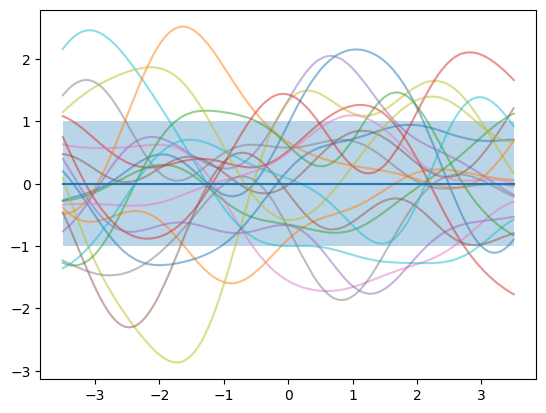

In [ ]:
# generate some test points
xtest = jnp.linspace(-3.5, 3.5, 500).reshape(-1, 1)

# predict from the prior
prior_dist = prior.predict(xtest)

# generate samples from the prior and do prediction
prior_mean = prior_dist.mean()
prior_std = prior_dist.variance()
samples = prior_dist.sample(seed=key, sample_shape=(20,))

# plot the prior samples
fig, ax = plt.subplots()
ax.plot(xtest, samples.T, alpha=0.5, label="Prior samples")
ax.plot(xtest, prior_mean,  label="Prior mean")
ax.fill_between(
    xtest.flatten(),
    prior_mean - prior_std,
    prior_mean + prior_std,
    alpha=0.3,
    label="Prior variance",
)
# ax.legend(loc="best")

In [ ]:
# Generate the likelihood

likelihood = gpx.likelihoods.Gaussian(num_datapoints=D.n)
posterior = prior * likelihood

# Generate the posterior predictive distribution
latent_dist = posterior.predict(xtest, train_data=D)
predictive_dist = posterior.likelihood(latent_dist)

# Extract the mean and variance of the posterior predictive distribution
predictive_mean = predictive_dist.mean()
predictive_std = predictive_dist.stddev()

/usr/local/lib/python3.10/dist-packages/cola/backends/backends.py:75: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(cls, tree_flatten, tree_unflatten)


In [ ]:
# Define the negative log marginal likelihood
negative_mll = gpx.objectives.ConjugateMLL(negative=True)
negative_mll = jit(negative_mll)

def fit_gp(x,y, key, do_optimize=True, obs_stddev=1e-3):
    """Fit a GP to the data (x,y) using the negative log marginal likelihood as the objective function.
    Args:
        x: input data
        y: output data
        key: random key
        do_optimize: whether to optimize the hyperparameters
        obs_stddev: observation noise
    Returns:
        posterior: the posterior distribution
    """

    D = gpx.Dataset(x, y)

    kernel = gpx.kernels.RBF()
    meanf = gpx.mean_functions.Zero()
    prior = gpx.gps.Prior(mean_function=meanf, kernel=kernel)

    likelihood = gpx.likelihoods.Gaussian(num_datapoints=D.n, obs_stddev=obs_stddev)
    posterior = prior * likelihood

    if do_optimize:
        # optimize the hyperparameters using Adam (this isn't great, but it works)
        # TODO: use a better optimizer
        # the optimizer needs optax to work
        opt_posterior, _ = gpx.fit(
        model=posterior,
        objective=negative_mll,
        num_iters=1000,
        train_data=D,
        optim=ox.adamw(learning_rate=0.01),
        key = key)

        return opt_posterior
    else:
        return posterior


def evaluate_posterior(x,y, x_eval, key, do_optimize=True, obs_stddev=1e-3):
    """Evaluate the posterior predictive distribution at x_eval.
    Args:
        x: input data
        y: output data
        x_eval: points at which to evaluate the posterior predictive distribution
        do_optimize: whether to optimize the hyperparameters
        obs_stddev: observation noise
    Returns:
        predictive_mean: mean of the posterior predictive distribution
        predictive_std: standard deviation of the posterior predictive distribution
    """

    D = gpx.Dataset(x, y)

    posterior = fit_gp(x,y, key, do_optimize=do_optimize, obs_stddev=obs_stddev)


    latent_dist = posterior.predict(x_eval, train_data=D)
    predictive_dist = posterior.likelihood(latent_dist)

    predictive_mean = predictive_dist.mean()
    predictive_std = predictive_dist.stddev()

    return predictive_mean, predictive_std

To select a new point, Sinsbeck and Nowak make use of the L2 risk function (also Jarvenpaa et al, 2021), as follows:

$$
    R(\theta^*) = \mathbb{E}_{y \sim f(x^*) |D}\int e^{2m_t(x; x^*, y) + s_t^2(x; x^*, y)}(e^{s_t^2(x; x^*, y)} - 1),
$$
where $m_t(x; x^*, y)$ is the posterior mean of the GP after conditioning on the current data set $D$ along with an additional point $(x^*, y)$.  The variance $s_t^2(x; x^*, y)$ is defined analogously.

To compute the expectation, we do Monte Carlo using exact samples of $y \sim f(x^*) |D$.  We typically use just $10$ samples.  Unsurprisingly this is very slow, and little bit unstable.

To compute the integral over $x$, we evaluate the gp over a fine mesh and use Euler integration.   This obviously cannot scale beyond a few dimensions.

So can we avoid the need to compute the expectation with respect to y?   

To do so, we follow the approach / derivations in [Jarvenpaa, 2021] which derive closed form distributions for the GP mean and GP variance.  

More specifically we can show that the loss function becomes
$$
        R(\theta^*) = \int e^{2m_t(x) + s_t^2(x)}(e^{\tau_t(x, x^*)} - 1),
$$
where
$$
\tau_t(x, x^*) = \frac{k_t(x, x^*)^2}{s_t(x^*)^2 + \sigma^2},
$$
where $\sigma^2$ is the variance of the observational noise and where

* $k_t$ is the kernel (i.e. two-point covariance) of the GP conditioned on $D$.
* $m_t$ is the mean of the GP conditioned on $D$.
* $s_t^2$ is the variance of the GP conditioned on $D$.

In [ ]:
# this computes k_t, the two point covariance function
def two_point_covariance(x_current, X, Y, posterior, jitter=1e-6):
    """Compute the two point covariance function.
    Args:
        x_current: current point
        X: input data
        Y: output data
        posterior: posterior distribution
        jitter: jitter for numerical stability
    Returns:
        covariance: two point covariance function
    """
    kernel = posterior.prior.kernel
    obs_noise = posterior.likelihood.obs_stddev**2

    Kxx = kernel.gram(x_current)
    Kxx += cola.ops.I_like(Kxx) * jitter

    #Sigma = Kxx + cola.ops.I_like(Kxx) * obs_noise
    #Sigma = cola.PSD(Sigma)

    KXY = kernel.cross_covariance(X, Y)
    KXx = kernel.cross_covariance(X, x_current)
    KxY = kernel.cross_covariance(x_current, Y)


    Sigma_inv_KxY = cola.solve(Kxx, KxY)

    covariance = KXY - jnp.matmul(KXx, Sigma_inv_KxY)

    return covariance

How do we interpret the loss function?

1. The $\mu_n$ weights points which have mean (exploitation)
2. The $\sigma_n^2$ weights points which have higher absolute variance (exploration).
3. The main term $\tau^2(a,b)$ is large when there's a strong correlation between $a$ and $b$, weighted by their standard deviation.

The tau effectively acts as a "bump" function which aggregates points around the design point.

In summary -- preferred design points will lie in a neighbourhood of large $\mu_n$ or large $\sigma^2_n$, thus effectively performing exploration / exploitation.

### Computational Cost

Every macro step of the algorithm is $O(N^3)$, where $N$ is the number of points evaluated
Within each macro-step you have cost $M*N^2$, where $M$ is the number of MCMC samples generated.

## 2023 paper

In [ ]:
# This removes the terms that don't depend on x_new
def loss_2023paper(x_current, y_current, x_new, x_grid, key, obs_stddev=1e-3):
    """Evaluate the L2 risk function at x_new.
    The code is vectorised over x_new, so you can just pass in a full grid of test points to evaluate it at

    This version removes the terms that don't depend on x_new, so it's faster than loss_fast.
    Args:
        x_current: input data
        y_current: output data
        x_new: point(s) at which to evaluate the risk function
        x_grid: points at which to evaluate the posterior predictive distribution
        key: random key
        obs_stddev: observation noise
    Returns:
        risk_value: risk function value
    """
    D = gpx.Dataset(x_current, y_current)

    posterior = fit_gp(x_current, y_current, key, do_optimize=False, obs_stddev=obs_stddev)

    latent_dist = posterior.predict(x_new, train_data=D)
    predictive_dist = posterior.likelihood(latent_dist)

    p_mean = predictive_dist.mean()#.reshape(-1,1)
    p_std = predictive_dist.stddev()#.reshape(-1,1)

    C = two_point_covariance(x_current, x_grid, x_new, posterior)
    #print(np.shape(C))


    tau2 = (C[0]-C[1])**2/(p_std**2 + obs_stddev**2)
    # utility_value =  jnp.mean(jnp.exp(2.0*p_mean**2 + p_std**2 - offset)*(jnp.exp(p_std**2) - jnp.exp(tau2)), axis=0)

    #log_loss = -logsumexp(2.0*p_mean + p_std**2 + tau2, axis=0)

    #return(log_loss)
    #print(np.shape(tau2))
    return(tau2)

In [ ]:
def epsilon_gamma(m,v,u):
  return norm.cdf(-jnp.abs(m-jnp.log(u)/jnp.sqrt(v)))

In [ ]:
def log_epsilon_gamma(m,v,u):
  return norm.logcdf(-jnp.abs(m-jnp.log(u)/jnp.sqrt(v)))

In [ ]:
#PRONE TO INSTABILITY
def expected(m,v):
  if m>=0:
    return norm.cdf(-m/v)-jnp.exp(u+(v**2)/2)*norm.cdf(-(m+v**2)/v)
  else:
    return norm.cdf(m/v)+jnp.exp(u+(v**2)/2)*(norm.cdf(-(m+v**2)/v)-2*norm.cdf(-v))

In [ ]:
def expected1(m,v):
  u = jnp.arange(0,1,0.05)
  return logsumexp(log_epsilon_gamma(m,v,u))

In [ ]:
# define x current and y_current
x_current = jnp.array([[-5., 5.]]).T
y_current = l(x_current)
# set up empty mh_samples
N = 10
mh_samples=np.zeros(N)
mh_samples[0]=0
epsilon = 0.3
obs_stddev=1e-3

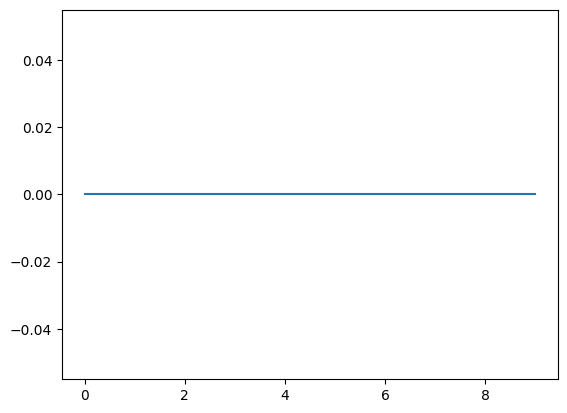

In [ ]:
plt.plot(mh_samples)

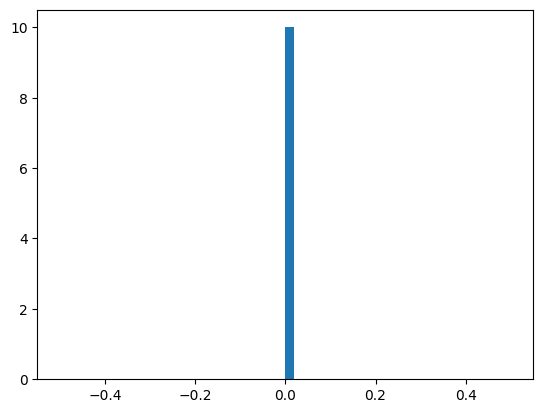

In [ ]:
plt.hist(mh_samples,bins=50)
plt.show()

(-100.0, 10.0)

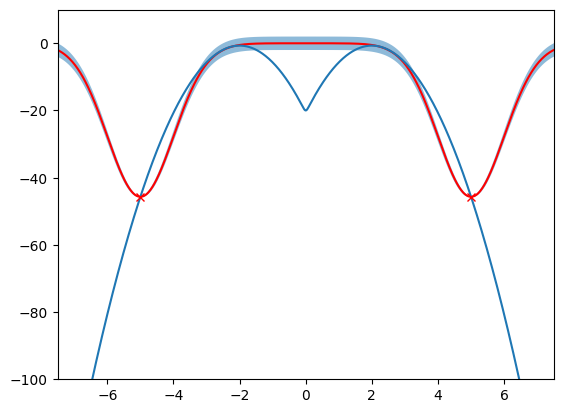

In [ ]:
# x_current = jnp.arange(-3.0,3.0, 0.1).reshape(-1, 1)
# y_current = l(x_current)

#xtest = jnp.linspace(-5.0, 5.0, 1000).reshape(-1, 1)
xtest = jnp.linspace(-10.0, 10.0, 1000).reshape(-1, 1)

p_mean, p_std = evaluate_posterior(x_current, y_current, xtest,key, do_optimize=False, obs_stddev=obs_stddev)
plt.plot(xtest.squeeze(),p_mean, color='red')
plt.plot(xtest.squeeze(),l(xtest))
plt.plot(x_current, y_current, 'x', color='red')

plt.fill_between(
    xtest.squeeze(),
    p_mean - 2 * p_std,
    p_mean + 2 * p_std,
    alpha=0.5,
    label="Two sigma",
)
plt.xlim(-7.5,7.5)
plt.ylim(-100,10)

In [ ]:
#make new eval posterior for this situation
def gpmh_eval_posterior1(posterior,x_prop,x_now,key,obs_stddev, D):
  x_eval = jnp.vstack([x_now,x_prop])

  x_eval = x_eval.reshape(-1,1)
  #D = gpx.Dataset(x_current, y_current)

  #posterior = fit_gp(x_current, y_current, key, do_optimize=False, obs_stddev=obs_stddev)

  latent_dist = posterior.predict(x_eval, train_data=D)
  predictive_dist = posterior.likelihood(latent_dist)
  m = predictive_dist.mean().reshape(-1,1)
  v = predictive_dist.stddev().reshape(-1,1)
  C = two_point_covariance(x_current, x_eval[0].reshape(-1,1), x_eval[1].reshape(-1,1), posterior)
  #print(m,x_eval)
  return m[1]-m[0],v[0]**2 + v[1]**2 - 2*C

## 2D STUFF

In [ ]:
import jax.numpy as jnp
from jax import jit

# Define the PDF of a bivariate normal distribution
def bivariate_normal_pdf(x, y, mu_x, mu_y, sigma_x, sigma_y, rho):
    sigma_x2 = sigma_x ** 2
    sigma_y2 = sigma_y ** 2
    rho2 = rho ** 2
    one_minus_rho2 = 1 - rho2

    z = ((x - mu_x) ** 2 / sigma_x2 +
         (y - mu_y) ** 2 / sigma_y2 -
         2 * rho * (x - mu_x) * (y - mu_y) / (sigma_x * sigma_y))

    normalization = 1 / (2 * jnp.pi * sigma_x * sigma_y * jnp.sqrt(one_minus_rho2))
    return normalization * jnp.exp(-z / (2 * one_minus_rho2))

# Define the log-likelihood function for a mixture of two bivariate normal distributions
def create_log_likelihood(mu_x1, mu_y1, sigma_x1, sigma_y1, rho1,
                          mu_x2, mu_y2, sigma_x2, sigma_y2, rho2, weight):
    @jit
    def log_likelihood(coordinate_pairs):
        # Split the coordinate pairs into x and y arrays
        coordinates = jnp.array(coordinate_pairs)
        x = coordinates[:, 0]
        y = coordinates[:, 1]

        # Compute the PDFs for each component
        pdf1 = bivariate_normal_pdf(x, y, mu_x1, mu_y1, sigma_x1, sigma_y1, rho1)
        pdf2 = bivariate_normal_pdf(x, y, mu_x2, mu_y2, sigma_x2, sigma_y2, rho2)

        # Combine the PDFs using the mixture weight
        combined_pdf = weight * pdf1 + (1 - weight) * pdf2

        # Compute the log-likelihood for each pair
        log_likelihood = jnp.log(combined_pdf)
        return log_likelihood

    return log_likelihood

# Example data
coordinate_pairs = [(1.0, 1.5), (2.0, 2.5), (3.0, 3.5)]

# Example parameters
mu_x1, mu_y1, sigma_x1, sigma_y1, rho1 = 2.0, 2.0, 1.0, 1.0, 0
mu_x2, mu_y2, sigma_x2, sigma_y2, rho2 = 4.0, 4.5, 1.0, 1.0, 0
weight = 1.

# Create the log-likelihood function with fixed parameters
log_likelihood_fn = create_log_likelihood(mu_x1, mu_y1, sigma_x1, sigma_y1, rho1,
                                          mu_x2, mu_y2, sigma_x2, sigma_y2, rho2, weight)

# Compute log-likelihoods for each coordinate pair
ll_values = log_likelihood_fn(coordinate_pairs)
print("Log-Likelihoods:", ll_values)


Log-Likelihoods: [-2.46287707 -1.96287707 -3.46287707]


In [ ]:
from jax.scipy.stats import multivariate_normal as mvn
#rv = mvn([0.5, -0.2], [[2.0, 0.3], [0.3, 0.5]])
log_likelihood_fn=jit(lambda x:mvn.logpdf(x,mean=jnp.array([2.,2.]),cov=jnp.array([[1.,0.],[0.,1.]])))

In [ ]:
log_likelihood_fn(jnp.array([2.,2.]))

Array(-1.83787707, dtype=float64)

In [ ]:
# define x current and y_current
x_current = jnp.array([[1.0, 1.5], [2.0, 2.0], [3.0, 3.5]])
y_current = jnp.array(log_likelihood_fn(x_current).reshape(-1,1))
# set up empty mh_samples
N = 100
mh_samples=np.zeros((N,2))
mh_samples[0,0]=3
mh_samples[0,1]=3
epsilon = 0.5
obs_stddev=1e-3
proposal='uniform'

In [ ]:
#make new eval posterior for this situation
def gpmh_eval_posterior_2d(posterior,x_current,x_prop,x_now,key,obs_stddev, D):
  x_eval = jnp.vstack((x_now,x_prop))

  #x_eval = x_eval.reshape(-1,1)
  #D = gpx.Dataset(x_current, y_current)

  #posterior = fit_gp(x_current, y_current, key, do_optimize=False, obs_stddev=obs_stddev)
  #print( x_eval[0], x_eval[1],x_current)
  latent_dist = posterior.predict(x_eval, train_data=D)
  predictive_dist = posterior.likelihood(latent_dist)
  m = predictive_dist.mean().reshape(-1,1)
  v = predictive_dist.stddev().reshape(-1,1)
  C = two_point_covariance(x_current, jnp.array([x_eval[0]]), jnp.array([x_eval[1]]), posterior)
  C1 = two_point_covariance(x_current, jnp.array([x_eval[0]]), jnp.array([x_eval[0]]), posterior)
  C2= two_point_covariance(x_current, jnp.array([x_eval[1]]), jnp.array([x_eval[1]]), posterior)
  print(v**2,C,C1,C2)
  #print(m,x_eval)
  return m[1]-m[0],v[0]**2 + v[1]**2 - 2*C

In [ ]:
D = gpx.Dataset(x_current, y=y_current)

posterior = fit_gp(x_current, y_current, key, do_optimize=False, obs_stddev=obs_stddev)
for i in range(1,N):
  # centred around prev step with var 1
  if proposal == 'uniform':
    x_prop = (np.random.uniform(0,1,2) - 0.5)*1 + mh_samples[i-1,:]
  else:
    x_prop=(np.random.normal()*1 + mh_samples[i-1])
  u = np.random.uniform()
  x_now=mh_samples[i-1]
  # find mean and variance at proposal and prev point
  #m,v = gpmh_eval_posterior(x_current,y_current,x_prop,x_now,key,obs_stddev)

  m,v = gpmh_eval_posterior_2d(posterior,x_current,x_prop,x_now,key,obs_stddev,D)

  print('step',i,epsilon_gamma(m,v,u),jnp.exp(expected1(m,v)),'Current',x_now,'proposed',x_prop)

  #while epsilon_gamma(m,v,u) > epsilon and np.size(x_current) < 150:
  while (expected1(m,v) > jnp.log(epsilon) and epsilon_gamma(m,v,u)>0.1) and np.size(x_current) < 400:
    obs_stddev = 1e-3
    num_samples= 10

    #x_grid = jnp.arange(-5.0, 5.0, 0.01).reshape(-1, 1)
    x_grid = jnp.vstack([x_now,x_prop])#.reshape(-1,1)

    test_points = jnp.arange(-7.5, 7.5, 0.1)
    test_points=jnp.array([[1.,1.],[2.,2.],[-1.,-1.]])
    x_range = jnp.arange(start = 1., stop = 6., step = 0.25 )
    y_range = jnp.arange(start = 1., stop = 6., step = 0.25 )

    x_gridvalues, y_gridvalues = jnp.meshgrid(x_range, y_range)
    test_points = jnp.vstack([x_gridvalues.flatten(), y_gridvalues.flatten()]).T
    '''
    max=round(jnp.max(x_grid),1)
    min=round(jnp.min(x_grid),1)

    #get lengthscale
    ls = posterior.prior.kernel.lengthscale
    print('lengthsxale:',ls)
    test_points = jnp.arange(min-round(5*ls,1), round(ls*5,1), 0.1)
    '''
    test_points= jnp.round(test_points,1)
    #test_points= jnp.array([testpt for testpt in test_points if testpt not in x_current])
    #test_points= jnp.round(test_points,1)
    #print(np.shape(test_points))
    test_point_utilities = loss_2023paper(x_current, y_current, test_points, x_grid, key, obs_stddev)
    '''
    temp_flag = np.any(test_point_utilities)
    while temp_flag == False:
      test_points = jnp.arange(-7.5, 7.5, 0.1)
      test_points= jnp.array([testpt for testpt in test_points if testpt not in x_current])
      #print(np.shape(test_points))
      test_point_utilities = loss_2023paper(x_current, y_current, test_points.reshape(-1,1), x_grid, key, obs_stddev)
      temp_flag = np.any(test_point_utilities)
    '''
    j = jnp.argmax(jnp.array(test_point_utilities))
    x_new = test_points[j]
    y_new = l(x_new)
    x_current = jnp.vstack([x_current, x_new])
    ##x_current = x_current.sort(axis=0)
    y_current = log_likelihood_fn(x_current).reshape(-1,1)
    #y_current = jnp.vstack([y_current, y_new])
    D = gpx.Dataset(x_current, y_current)

    posterior = fit_gp(x_current, y_current, key, do_optimize=False, obs_stddev=obs_stddev)
    m,v = gpmh_eval_posterior_2d(posterior,x_current,x_prop,x_now,key,obs_stddev, D)
    print('chosen new point',x_new,'size',np.shape(x_current),jnp.exp(expected1(m,v)))
  print('m',m,'v',v,u)
  if m >= jnp.log(u):
    mh_samples[i] = x_prop
  else:
    mh_samples[i] = mh_samples[i-1]





step 1 [[9.83708863e-11]] 2.3273142755297744 Current [3. 3.] proposed [2.97428355 3.05508965]
m [-0.0213824] v [[0.15667741]] 0.07986324381867127
step 2 [[3.87864706e-10]] 1.2711712217837796 Current [2.97428355 3.05508965] proposed [2.76670114 3.03495456]
m [0.39761978] v [[0.1423355]] 0.11416018051088128
step 3 [[0.23978536]] 1.9860575453963027 Current [2.76670114 3.03495456] proposed [2.90506905 2.63233217]
chosen new point [3.  2.2] size (5, 2) 1.493410763289298
chosen new point [2.2 3.2] size (6, 2) 1.0622963889114823
chosen new point [3.  1.5] size (7, 2) 0.6465938584397065
m [0.31469059] v [[0.03018561]] 0.8022856578614591
step 4 [[0.26507179]] 0.8378006879788105 Current [2.90506905 2.63233217] proposed [3.1090468  2.16336057]
chosen new point [2.8 2.5] size (8, 2) 0.24232998038136994
m [0.0596665] v [[0.00407335]] 0.9219721417517811
step 5 [[9.02093659e-22]] 1.1597955414128394 Current [3.1090468  2.16336057] proposed [3.3237988  1.82904813]
m [-0.11909693] v [[0.02956509]] 0.190

KeyboardInterrupt: 

In [ ]:
# x_current = jnp.arange(-3.0,3.0, 0.1).reshape(-1, 1)
# y_current = l(x_current)

#xtest = jnp.linspace(-5.0, 5.0, 1000).reshape(-1, 1)
x_range = jnp.arange(start = 1., stop = 6., step = 0.1)
y_range = jnp.arange(start = 1., stop = 6., step = 0.1 )

x_gridvalues, y_gridvalues = jnp.meshgrid(x_range, y_range)
xtest = jnp.vstack([x_gridvalues.flatten(), y_gridvalues.flatten()]).T

p_mean, p_std = evaluate_posterior(x_current, y_current, xtest,key, do_optimize=False, obs_stddev=obs_stddev)
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
#pc=ax.pcolormesh(x_gridvalues, y_gridvalues, p_mean.reshape(15,15))
pc=ax.contour(x_gridvalues, y_gridvalues, p_mean.reshape(50,50))
fig.colorbar(pc)
plt.show()


ValueError: Inputs, X, and outputs, y, must have the same number of rows. Got X.shape=(114, 2) and y.shape=(113, 1).

## Lotka Volterra

In [ ]:
# what is the lotka-volterra likelihood
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# Define the Lotka-Volterra equations
def lotka_volterra(X, t, alpha, beta, delta, gamma):
    x, y = X
    dxdt = alpha * x - beta * x * y
    dydt = delta * x * y - gamma * y
    return [dxdt, dydt]

# Generate synthetic data using known parameters
def generate_synthetic_data(true_params, initial_conditions, t):
    return odeint(lotka_volterra, initial_conditions, t, args=tuple(true_params))

# Define the likelihood function
def log_likelihood(log_params, t, data, initial_conditions):
    params=np.exp(log_params)
    alpha, beta, delta, gamma = params
    model = odeint(lotka_volterra, initial_conditions, t, args=(alpha, beta, delta, gamma))
    error = data - model
    return -np.sum(error**2) / 2

# Define the Metropolis-Hastings algorithm
def metropolis_hastings(log_likelihood, initial_params, t, data, initial_conditions, n_iterations, proposal_width):
    params = np.array(initial_params)
    log_likelihood_current = log_likelihood(params, t, data, initial_conditions)
    samples = [params]

    for i in range(n_iterations):
        # Propose new parameters
        params_new = params + (np.random.uniform(0,1, size=params.shape)-0.5)*proposal_width
        log_likelihood_new = log_likelihood(params_new, t, data, initial_conditions)

        # Acceptance criterion
        if np.random.rand() < np.exp(log_likelihood_new - log_likelihood_current):
            params = params_new
            log_likelihood_current = log_likelihood_new

        print(i)
        samples.append(params)

    return np.array(samples)




In [ ]:
# True parameters for generating synthetic data
true_params = [2.0, 0.1, 0.1, 1.5]
initial_conditions = [10, 5]
t = np.linspace(0, 50, 500)
data = generate_synthetic_data(true_params, initial_conditions, t)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25


<ipython-input-6-9d0be5314d05>:37: RuntimeWarning: overflow encountered in exp
  if np.random.rand() < np.exp(log_likelihood_new - log_likelihood_current):


Streaming output truncated to the last 5000 lines.
5000
5001
5002
5003
5004
5005
5006
5007
5008
5009
5010
5011
5012
5013
5014
5015
5016
5017
5018
5019
5020
5021
5022
5023
5024
5025
5026
5027
5028
5029
5030
5031
5032
5033
5034
5035
5036
5037
5038
5039
5040
5041
5042
5043
5044
5045
5046
5047
5048
5049
5050
5051
5052
5053
5054
5055
5056
5057
5058
5059
5060
5061
5062
5063
5064
5065
5066
5067
5068
5069
5070
5071
5072
5073
5074
5075
5076
5077
5078
5079
5080
5081
5082
5083
5084
5085
5086
5087
5088
5089
5090
5091
5092
5093
5094
5095
5096
5097
5098
5099
5100
5101
5102
5103
5104
5105
5106
5107
5108
5109
5110
5111
5112
5113
5114
5115
5116
5117
5118
5119
5120
5121
5122
5123
5124
5125
5126
5127
5128
5129
5130
5131
5132
5133
5134
5135
5136
5137
5138
5139
5140
5141
5142
5143
5144
5145
5146
5147
5148
5149
5150
5151
5152
5153
5154
5155
5156
5157
5158
5159
5160
5161
5162
5163
5164
5165
5166
5167
5168
5169
5170
5171
5172
5173
5174
5175
5176
5177
5178
5179
5180
5181
5182
5183
5184
5185
5186
5187
5188
5189

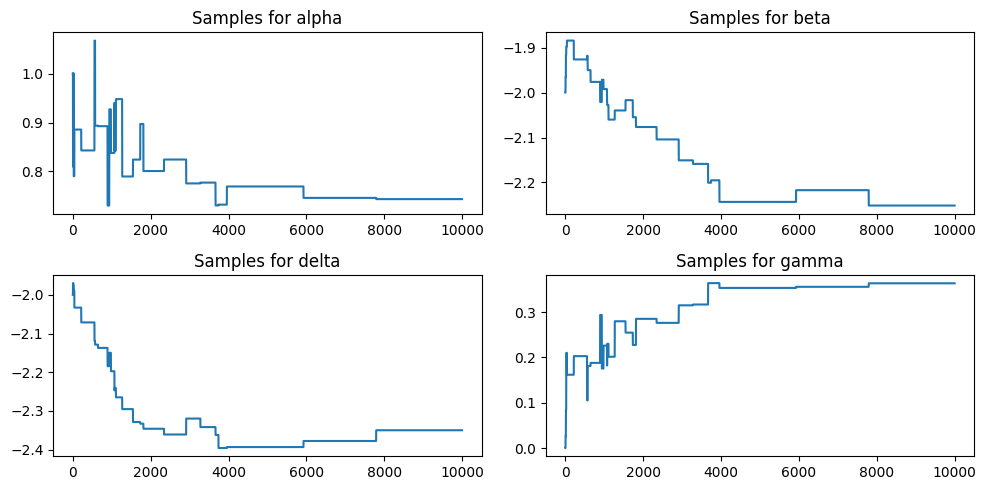

[2.10322658 0.10525787 0.09539323 1.43897243]


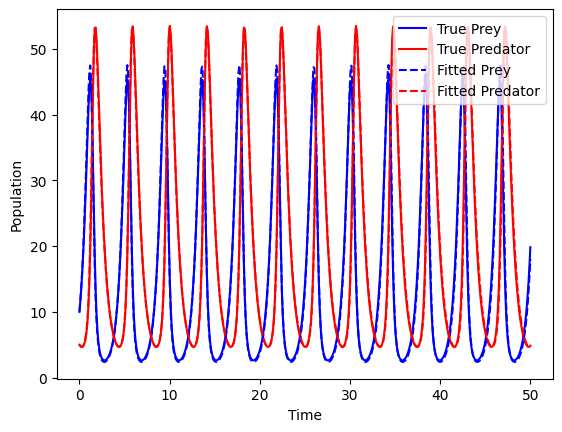

In [ ]:


# Initial guess for parameters
initial_params = [1.0, -2.0, -2.0, 0.0]
n_iterations = 10000
proposal_width = [0.5,0.1,0.1,0.5]

# Run the Metropolis-Hastings algorithm
samples = metropolis_hastings(log_likelihood, initial_params, t, data, initial_conditions, n_iterations, proposal_width)

# Plot the results
plt.figure(figsize=(10, 5))
for i, param in enumerate(['alpha', 'beta', 'delta', 'gamma']):
    plt.subplot(2, 2, i + 1)
    plt.plot(samples[:, i])
    plt.title(f'Samples for {param}')
plt.tight_layout()
plt.show()

# Plot the fitted model vs true data
best_params = samples[np.argmax([log_likelihood(p, t, data, initial_conditions) for p in samples])]
fitted_model = generate_synthetic_data(np.exp(best_params), initial_conditions, t)
print(np.exp(best_params))
plt.figure()
plt.plot(t, data[:, 0], 'b-', label='True Prey')
plt.plot(t, data[:, 1], 'r-', label='True Predator')
plt.plot(t, fitted_model[:, 0], 'b--', label='Fitted Prey')
plt.plot(t, fitted_model[:, 1], 'r--', label='Fitted Predator')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Population')
plt.show()


# thoughts for likelihood
simulate likelihood for the data given different parameters
choosing new points means choosing new parameters to fit the model
if u want the likelihood to be normal

In [ ]:
# Define the likelihood function


# Define the likelihood function
def log_likelihood_lv(params):#, t, data, initial_conditions):
    alpha=params[:,0]
    beta=params[:,1]
    delta= 0.1
    gamma=1.5

    model = odeint(lotka_volterra, initial_conditions, t, args=(alpha, beta, delta, gamma))
    error = data - model
    return -np.sum(error**2) / 2

In [ ]:
def log_likelihood_lv(params):#, t, data, initial_conditions):
    alpha = params[:, 0][:, np.newaxis]
    beta = params[:, 1][:, np.newaxis]
    delta = 0.1
    gamma = 1.5

    def model_eq(X, t, alpha, beta):
        x, y = X
        dxdt = alpha * x - beta * x * y
        dydt = delta * x * y - gamma * y
        return [dxdt, dydt]

    # Vectorized integration for all parameter sets
    def integrate_model(alpha, beta):
        model = odeint(model_eq, initial_conditions, t, args=(alpha, beta))
        return model

    # Apply integration for each parameter set
    models = np.array([integrate_model(alpha_i, beta_i) for alpha_i, beta_i in zip(alpha, beta)])

    # Compute error for each parameter set
    sigma=10
    errors = data - models
    log_likelihoods = -np.sum(errors**2, axis=(1, 2)) / 2*sigma**2
    return log_likelihoods

In [ ]:
from jax import vmap
from jax.experimental.ode import odeint

In [ ]:
def lotka_volterra(X, t, alpha, beta, delta, gamma):
    x, y = X
    dxdt = alpha * x - beta * x * y
    dydt = delta * x * y - gamma * y
    return [dxdt, dydt]

# Vectorized integration function
def integrate_model(params, t, initial_conditions):
    alpha, beta = params
    delta=0.1
    gamma=1.5
    # Define the ODE function for a single set of parameters
    def odefunc(X, t):
        return lotka_volterra(X, t, alpha, beta, delta, gamma)

    # Integrate the ODE
    return odeint(odefunc, initial_conditions, t)

# Vectorized log-likelihood function
@jit
def log_likelihood_lv(params):#, t, data, initial_conditions):
    # Ensure params are in the correct shape (N, 4) where N is the number of parameter sets
    def integrate_single(params):
        return integrate_model(params, t, initial_conditions)

    # Vectorize integration over parameter sets
    models = vmap(integrate_single)(params)

    # Compute the error and log-likelihood for each parameter set
    errors = data - models

    sigma=1
    log_likelihoods = -jnp.sum(errors**2, axis=(1, 2)) / (2*sigma**2)
    return log_likelihoods

# Example data
true_params = jnp.array([2.0, 0.1])
initial_conditions = jnp.array([10.0, 5.0])
t = jnp.linspace(0, 50, 500)
data = integrate_model(true_params, t, initial_conditions)

# Initial guess for parameters
initial_params = jnp.array([[1.0, 0.05], [2.0, 0.1],[1.1,1.1]])

# Compute log-likelihoods for each parameter set
ll_values = log_likelihood_lv(initial_params)#, t, data, initial_conditions)
print("Log-Likelihoods:", ll_values)

Log-Likelihoods: [-2.07489876e+05 -2.51908776e-22 -2.78761503e+05]


In [ ]:
# define x current and y_current
params_current = jnp.array([[1.0, 0.1], [2.0, 0.2], [1.5, 0.3],[0.1,0.1]])
true_params = jnp.array([2.0, 0.1])
initial_conditions = jnp.array([10.0, 5.0])
t = jnp.linspace(0, 50, 500)
#data = generate_synthetic_data(true_params, initial_conditions, t)
y_current = jnp.array(log_likelihood_lv(params_current).reshape(-1,1))
# set up empty mh_samples
N = 100
mh_samples=np.zeros((N,2))
mh_samples[0,0]=3.0
mh_samples[0,1]=1.0
epsilon = 0.1
obs_stddev=1e-1
proposal='uniform'

In [ ]:
y_current

Array([[-163336.97617133],
       [-158622.37394401],
       [-198245.35185141],
       [-216505.26507197]], dtype=float64)

In [ ]:
D = gpx.Dataset(params_current, y=y_current)

posterior = fit_gp(params_current, y_current, key, do_optimize=False, obs_stddev=obs_stddev)
for i in range(1,N):
  # centred around prev step with var 1
  if proposal == 'uniform':
    params_prop = (np.random.uniform(0,1,2) - 0.5)*0.5 + mh_samples[i-1,:]
  else:
    params_prop=(np.random.normal()*1 + mh_samples[i-1])
  u = np.random.uniform()
  params_now=mh_samples[i-1]
  # find mean and variance of log likelihood ratio at proposal and prev point
  m,v = gpmh_eval_posterior_2d(posterior,params_prop,params_now,key,obs_stddev,D)

  print('step',i,log_epsilon_gamma(m,v,u),expected1(m,v),jnp.log(epsilon),'Current',params_now,'proposed',params_prop)

  #while epsilon_gamma(m,v,u) > epsilon and np.size(x_current) < 150:
  while (expected1(m,v) > jnp.log(epsilon) or log_epsilon_gamma(m,v,u)>jnp.log(0.1)) and np.size(x_current) < 400:
    obs_stddev = 1e-3
    num_samples= 10

    #x_grid = jnp.arange(-5.0, 5.0, 0.01).reshape(-1, 1)
    params_grid = jnp.vstack([params_now,params_prop])#.reshape(-1,1)

    # how many do you need to set up
    x_range = jnp.arange(start = 1., stop = 6., step = 0.25 )
    y_range = jnp.arange(start = 1., stop = 6., step = 0.25 )

    x_gridvalues, y_gridvalues = jnp.meshgrid(x_range, y_range)
    test_points = jnp.vstack([x_gridvalues.flatten(), y_gridvalues.flatten()]).T
    '''
    max=round(jnp.max(x_grid),1)
    min=round(jnp.min(x_grid),1)

    #get lengthscale
    ls = posterior.prior.kernel.lengthscale
    print('lengthsxale:',ls)
    test_points = jnp.arange(min-round(5*ls,1), round(ls*5,1), 0.1)
    '''
    test_points= jnp.round(test_points,1)
    ## this remove points done needs work
    #test_points= jnp.array([testpt for testpt in test_points if testpt not in x_current])
    #test_points= jnp.round(test_points,1)
    #print(np.shape(test_points))
    test_point_utilities = loss_2023paper(params_current, y_current, test_points,params_grid, key, obs_stddev)

    j = jnp.argmax(jnp.array(test_point_utilities))
    params_new = test_points[j]
    y_new = l(x_new)
    params_current = jnp.vstack([params_current, params_new])
    y_current = log_likelihood_lv(params_current).reshape(-1,1)
    D = gpx.Dataset(params_current, y_current)

    posterior = fit_gp(params_current, y_current, key, do_optimize=False, obs_stddev=obs_stddev)
    m,v = gpmh_eval_posterior_2d(posterior,params_prop,params_now,key,obs_stddev, D)
    print('chosen new point',params_new,'size',np.shape(params_current),jnp.exp(expected1(m,v)))
  print('m',m,'v',v,u)
  if m >= jnp.log(u):
    mh_samples[i] = params_prop
  else:
    mh_samples[i] = mh_samples[i-1]


step 1 [[-39856658.81883582]] -39828348.3122089 -2.3025850929940455 Current [3. 1.] proposed [2.77515038 0.75555492]
m [8924.98848701] v [[0.53046926]] 0.09430946438874388
step 2 [[-4.36803014e+08]] -436766729.96239364 -2.3025850929940455 Current [2.77515038 0.75555492] proposed [2.98274481 0.52716252]
m [29555.53587889] v [[0.65849211]] 0.3508186552741369
step 3 [[-4.58513521e+08]] -458399641.06738967 -2.3025850929940455 Current [2.98274481 0.52716252] proposed [3.0633095  0.31793946]
m [30278.63605784] v [[0.80680797]] 0.03240787153782754
step 4 [[-5.27518421e+08]] -527396117.63585544 -2.3025850929940455 Current [3.0633095  0.31793946] proposed [3.14247468 0.10529535]
m [32477.51069698] v [[0.90020412]] 0.02667530120737671
step 5 [[-1.15604903e+08]] -115593179.58203709 -2.3025850929940455 Current [3.14247468 0.10529535] proposed [3.33264768 0.19327749]
m [-15207.89707097] v [[0.94352739]] 0.10573641888281293
step 6 [[-13894280.53223416]] -13883759.863563728 -2.3025850929940455 Curren

## 4d

In [ ]:
from jax import vmap
from jax.experimental.ode import odeint

In [ ]:
def lotka_volterra(X, t, alpha, beta, delta, gamma):
    x, y = X
    dxdt = alpha * x - beta * x * y
    dydt = delta * x * y - gamma * y
    return [dxdt, dydt]

# Vectorized integration function
def integrate_model(params, t, initial_conditions):
    alpha, beta, delta, gamma = params

    # Define the ODE function for a single set of parameters
    def odefunc(X, t):
        return lotka_volterra(X, t, alpha, beta, delta, gamma)

    # Integrate the ODE
    return odeint(odefunc, initial_conditions, t)

# Vectorized log-likelihood function
@jit
def log_likelihood_lv(log_params):#, t, data, initial_conditions):
    # Ensure params are in the correct shape (N, 4) where N is the number of parameter sets
    params=jnp.exp(log_params)
    def integrate_single(params):
        return integrate_model(params, t, initial_conditions)

    # Vectorize integration over parameter sets
    models = vmap(integrate_single)(params)

    # Compute the error and log-likelihood for each parameter set
    errors = data - models

    sigma=10
    log_likelihoods = -jnp.sum(errors**2, axis=(1, 2)) / (2*sigma**2)
    return log_likelihoods

# Example data
true_params = jnp.array([2.0, 0.1,0.1,1.5])
initial_conditions = jnp.array([10.0, 5.0])
t = jnp.linspace(0, 50, 500)
data = integrate_model(true_params, t, initial_conditions)

# Initial guess for parameters
initial_params = jnp.array([[1.0, 0.05,1.0,0.1], [2.0, 0.1,2.0,0.1],[1.1,1.1,1.1,1.1]])

# Compute log-likelihoods for each parameter set
ll_values = log_likelihood_lv(initial_params)#, t, data, initial_conditions)
print("Log-Likelihoods:", ll_values)

Log-Likelihoods: [-2469.54375493 -2544.23758623 -2527.23380635]


In [ ]:
# define x current and y_current
params_current =  jnp.array([[1.5, 1.5,1.5,1.5], [2.0, 0.1,2.0,0.1],[-1.5,-1.5,-1.5,-1.5],[-5.0,-2.5,-2.5,-5.0],[5.0,2.5,2.5,5.0]])
true_params = jnp.array([2.0, 0.1,0.1,1.5])
initial_conditions = jnp.array([10.0, 5.0])
t = jnp.linspace(0, 50, 500)
#data = generate_synthetic_data(true_params, initial_conditions, t)
y_current = jnp.array(log_likelihood_lv(params_current).reshape(-1,1))
# set up empty mh_samples
N = 3000
mh_samples=np.zeros((N,4))
###mh_samples[0,0]=
#mh_samples[0,1]=-1.0
#mh_samples[0,2]=-1.0
#mh_samples[0,3]=-1.0
mh_samples[0]=np.array([0.5,-2.0,-2.5,-0.5])
epsilon = 0.3
obs_stddev=1e-3
proposal='uniform'

In [ ]:
mh_samples

array([[ 1., -2., -2.,  0.],
       [ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.]])

In [ ]:
D = gpx.Dataset(params_current, y=y_current)

posterior = fit_gp(params_current, y_current, key, do_optimize=True, obs_stddev=obs_stddev)
for i in range(1,N):
  # centred around prev step with var 1
  if proposal == 'uniform':
    params_prop = (np.random.uniform(0,1,4) - 0.5)*[0.1,0.1,0.1,0.1] + mh_samples[i-1,:]
  else:
    params_prop=(np.random.normal()*1 + mh_samples[i-1])
  u = np.random.uniform()
  params_now=mh_samples[i-1]
  # find mean and variance of log likelihood ratio at proposal and prev point
  m,v = gpmh_eval_posterior_2d(posterior,params_current,params_prop,params_now,key,obs_stddev,D)

  print('step',i,log_epsilon_gamma(m,v,u),expected1(m,v),jnp.log(epsilon),'Current',params_now,'proposed',params_prop)

  #while epsilon_gamma(m,v,u) > epsilon and np.size(x_current) < 150:
  while (expected1(m,v) > jnp.log(epsilon) or log_epsilon_gamma(m,v,u)>jnp.log(0.1)) and np.size(params_current) < 150:
    obs_stddev = 1e-3
    num_samples= 10

    #x_grid = jnp.arange(-5.0, 5.0, 0.01).reshape(-1, 1)
    params_grid = jnp.vstack([params_now,params_prop])#.reshape(-1,1)

    # how many do you need to set up
    x1_range = jnp.arange(start = -3., stop = 3., step = 1.0 )
    x2_range = jnp.arange(start = -3., stop = 3., step = 1.0 )
    x3_range = jnp.arange(start = -3., stop = 3., step = 1.0 )
    x4_range = jnp.arange(start = -2., stop = 2., step = 1.0 )

    x1_gridvalues, x2_gridvalues, x3_gridvalues,x4_gridvalues = jnp.meshgrid(x1_range, x2_range,x3_range,x4_range)
    test_points = jnp.vstack([x1_gridvalues.flatten(), x2_gridvalues.flatten(), x3_gridvalues.flatten(), x4_gridvalues.flatten()]).T
    '''
    max=round(jnp.max(x_grid),1)
    min=round(jnp.min(x_grid),1)

    #get lengthscale
    ls = posterior.prior.kernel.lengthscale
    print('lengthsxale:',ls)
    test_points = jnp.arange(min-round(5*ls,1), round(ls*5,1), 0.1)
    '''
    #test_points= jnp.round(test_points,1)
    ## this remove points done needs work, converts to np.array
    #test_points= jnp.array([testpt for testpt in test_points if testpt not in np.array(params_current)])
    #print(test_points)
    #test_points= jnp.round(test_points,1)
    #print(np.shape(test_points))
    test_point_utilities = loss_2023paper(params_current, y_current, test_points,params_grid, key, obs_stddev)

    j = jnp.argmax(jnp.array(test_point_utilities))
    params_new = test_points[j]
    #y_new = log_likelihood_lv(params_new)
    params_current = jnp.vstack([params_current, params_new])
    y_current = log_likelihood_lv(params_current).reshape(-1,1)
    D = gpx.Dataset(params_current, y_current)

    posterior = fit_gp(params_current, y_current, key, do_optimize=True, obs_stddev=obs_stddev)
    m,v = gpmh_eval_posterior_2d(posterior,params_current,params_prop,params_now,key,obs_stddev, D)
    print('chosen new point',params_new,'size',np.shape(params_current),jnp.exp(expected1(m,v)))
  print('m',m,'v',v,u)
  if m >= jnp.log(u):
    mh_samples[i] = params_prop
  else:
    mh_samples[i] = mh_samples[i-1]


  0%|          | 0/1000 [00:00<?, ?it/s]

[[42.03352714]
 [42.03611915]] [[0.89602814]] [[0.88414196]] [[0.90850578]]
step 1 [[-6.24151169]] -2.5248301157666413 -1.2039728043259361 Current [ 0.5 -2.  -2.5 -0.5] proposed [ 0.53056679 -2.03253304 -2.53322614 -0.52580873]
m [2.54157852] v [[82.27759]] 0.043720849346080004
[[42.03611915]
 [42.0333161 ]] [[0.89480142]] [[0.90850578]] [[0.88165069]]
step 2 [[-5.62396742]] -2.3832274179155046 -1.2039728043259361 Current [ 0.53056679 -2.03253304 -2.53322614 -0.52580873] proposed [ 0.50028171 -2.00818162 -2.49190069 -0.50668656]
m [-2.69833191] v [[82.27983241]] 0.8982021099032221
[[42.03611915]
 [42.03663107]] [[0.91208605]] [[0.90850578]] [[0.91591145]]
step 3 [[-1.12073244]] 1.8583175517395227 -1.2039728043259361 Current [ 0.53056679 -2.03253304 -2.53322614 -0.52580873] proposed [ 0.54775072 -2.06234069 -2.51628913 -0.52477433]


  0%|          | 0/1000 [00:00<?, ?it/s]

[[33.41705181]
 [33.41523858]] [[0.56654709]] [[0.5788882]] [[0.55462923]]
chosen new point [ 1. -3. -2. -1.] size (6, 4) 2.099805696212331e-12
m [-7.49242848] v [[65.69919622]] 0.30209147540874526
[[33.41705181]
 [33.42274934]] [[0.60374123]] [[0.5788882]] [[0.63050613]]
step 4 [[-90.44579953]] -83.32144368437756 -1.2039728043259361 Current [ 0.53056679 -2.03253304 -2.53322614 -0.52580873] proposed [ 0.54484675 -1.98443536 -2.54614218 -0.48102157]
m [12.7924854] v [[65.63231869]] 0.04108444620210927
[[33.42274934]
 [33.42381225]] [[0.63301468]] [[0.63050613]] [[0.63655385]]
step 5 [[-0.91013482]] 2.102885880794342 -1.2039728043259361 Current [ 0.54484675 -1.98443536 -2.54614218 -0.48102157] proposed [ 0.57437215 -1.96909723 -2.5184879  -0.4574412 ]


  0%|          | 0/1000 [00:00<?, ?it/s]

[[33.50448086]
 [33.49463448]] [[1.82921559]] [[1.88793923]] [[1.77752201]]
chosen new point [ 1. -2. -2.  0.] size (7, 4) 0.0008382369099856994
m [-4.05873213] v [[63.34068415]] 0.7769184856261471
[[33.50448086]
 [33.49674535]] [[1.84328611]] [[1.88793923]] [[1.80599276]]
step 6 [[-84.98586306]] -80.61551827314106 -1.2039728043259361 Current [ 0.54484675 -1.98443536 -2.54614218 -0.48102157] proposed [ 0.5666218  -1.97265622 -2.50839882 -0.48607726]
m [-12.85589059] v [[63.31465399]] 0.4978410802799348
[[33.50448086]
 [33.49836994]] [[1.85450685]] [[1.88793923]] [[1.83628538]]
step 7 [[-715.4883831]] -703.2561403453628 -1.2039728043259361 Current [ 0.54484675 -1.98443536 -2.54614218 -0.48102157] proposed [ 0.58881531 -2.0235086  -2.54133204 -0.50518463]
m [-37.7599834] v [[63.2938371]] 0.6602062752833032
[[33.50448086]
 [33.4914251 ]] [[1.80998353]] [[1.88793923]] [[1.75239046]]
step 8 [[-362.35093247]] -352.9575607121259 -1.2039728043259361 Current [ 0.54484675 -1.98443536 -2.54614218

  0%|          | 0/1000 [00:00<?, ?it/s]

[[33.34131661]
 [33.34151385]] [[1.31388848]] [[1.31994617]] [[1.30985287]]
chosen new point [ 0. -3. -3.  0.] size (8, 4) 4.526988560905462e-06
m [4.94025064] v [[64.0550535]] 0.7472112312623759
[[33.34151385]
 [33.3379646 ]] [[1.30361328]] [[1.30985287]] [[1.31008513]]
step 17 [[-394.5641412]] -386.50909487603525 -1.2039728043259361 Current [ 0.44476543 -1.86949207 -2.69725093 -0.43789677] proposed [ 0.3964322  -1.90846115 -2.66306324 -0.48122538]
m [-28.02896427] v [[64.07225189]] 0.48949265377971973
[[33.34151385]
 [33.34528722]] [[1.31984887]] [[1.30985287]] [[1.3338565]]
step 18 [[-142.8867852]] -140.2494742003343 -1.2039728043259361 Current [ 0.44476543 -1.86949207 -2.69725093 -0.43789677] proposed [ 0.40828921 -1.87768091 -2.73023807 -0.41381572]
m [16.63153865] v [[64.04710334]] 0.6660322313773172
[[33.34528722]
 [33.34941309]] [[1.35833789]] [[1.3338565]] [[1.39024905]]
step 19 [[-45.69163874]] -42.92638552612991 -1.2039728043259361 Current [ 0.40828921 -1.87768091 -2.7302380

  0%|          | 0/1000 [00:00<?, ?it/s]

[[33.16298387]
 [33.16683346]] [[1.09345497]] [[1.07013026]] [[1.11834871]]
chosen new point [ 1. -1. -3. -1.] size (9, 4) 6.300469855484458


  0%|          | 0/1000 [00:00<?, ?it/s]

[[32.9651584 ]
 [32.96367355]] [[0.30770856]] [[0.31059468]] [[0.30534229]]
chosen new point [ 0. -2. -3.  0.] size (10, 4) 2.0615160388340854


  0%|          | 0/1000 [00:00<?, ?it/s]

[[32.73936566]
 [32.73466858]] [[0.15703994]] [[0.16312468]] [[0.15134154]]
chosen new point [ 0. -1. -3.  0.] size (11, 4) 0.12240729676459812
m [-2.61419254] v [[65.15995436]] 0.006976469328151991
[[32.73466858]
 [32.72779516]] [[0.15196262]] [[0.15134154]] [[0.15391624]]
step 63 [[-228.6761843]] -222.2870703349951 -1.2039728043259361 Current [ 0.2159011  -1.31324093 -3.07787693 -0.43912788] proposed [ 0.21953451 -1.3478009  -3.04845602 -0.44771048]
m [-21.27981361] v [[65.15853851]] 0.5212796313492961
[[32.73466858]
 [32.7364971 ]] [[0.16381178]] [[0.15134154]] [[0.18219285]]
step 64 [[-142.83322477]] -136.32160404635468 -1.2039728043259361 Current [ 0.2159011  -1.31324093 -3.07787693 -0.43912788] proposed [ 0.17390906 -1.35474126 -3.06003388 -0.48347788]
m [-16.6840357] v [[65.14354213]] 0.9611216163672981
[[32.73466858]
 [32.73736829]] [[0.15137197]] [[0.15134154]] [[0.15559676]]
step 65 [[-1.74566717]] 1.4307236316525078 -1.2039728043259361 Current [ 0.2159011  -1.31324093 -3.077

  0%|          | 0/1000 [00:00<?, ?it/s]

[[32.29364059]
 [32.28926225]] [[0.08609345]] [[0.08851051]] [[0.08481138]]
chosen new point [ 0. -1. -2. -1.] size (12, 4) 0.03615551483895472
m [-3.02422579] v [[64.41071594]] 0.10823346399759293
[[32.29364059]
 [32.2939729 ]] [[0.08472253]] [[0.08851051]] [[0.08256878]]
step 66 [[-7.99028585]] -5.290921215611798 -1.2039728043259361 Current [ 0.2159011  -1.31324093 -3.07787693 -0.43912788] proposed [ 0.26395903 -1.30309471 -3.08422958 -0.41530467]
m [3.36449396] v [[64.41816843]] 0.760919456482412
[[32.2939729 ]
 [32.29381303]] [[0.08214845]] [[0.08256878]] [[0.08180908]]
step 67 [[-0.98036356]] 2.0155996836112537 -1.2039728043259361 Current [ 0.26395903 -1.30309471 -3.08422958 -0.41530467] proposed [ 0.24503367 -1.32021005 -3.09207806 -0.40034219]


  0%|          | 0/1000 [00:00<?, ?it/s]

[[32.22366272]
 [32.22513591]] [[0.08623403]] [[0.08662443]] [[0.08591659]]
chosen new point [ 1. -1. -3.  0.] size (13, 4) 8.896967511063762


  0%|          | 0/1000 [00:00<?, ?it/s]

[[31.94947074]
 [31.95232609]] [[0.05856001]] [[0.05832653]] [[0.05884372]]
chosen new point [ 2. -1. -3. -1.] size (14, 4) 0.39546763304677923


  0%|          | 0/1000 [00:00<?, ?it/s]

[[31.64233871]
 [31.64661236]] [[0.04039857]] [[0.04002794]] [[0.04080581]]
chosen new point [ 1. -1. -3. -2.] size (15, 4) 0.0639728771451136
m [2.60546615] v [[63.20815395]] 0.595961030640891
[[31.64661236]
 [31.65227796]] [[0.04279134]] [[0.04080581]] [[0.04501662]]
step 68 [[-1.9129671]] 1.1500262728791348 -1.2039728043259361 Current [ 0.24503367 -1.32021005 -3.09207806 -0.40034219] proposed [ 0.22940226 -1.35421734 -3.11217718 -0.39433996]


  0%|          | 0/1000 [00:00<?, ?it/s]

[[32.04490944]
 [32.0487218 ]] [[0.05224136]] [[0.05054623]] [[0.05427883]]
chosen new point [ 0. -2. -3. -1.] size (16, 4) 5.575912840648846


  0%|          | 0/1000 [00:00<?, ?it/s]

[[31.95635272]
 [31.95981253]] [[0.04611326]] [[0.04498115]] [[0.04751163]]
chosen new point [ 0. -2. -2.  0.] size (17, 4) 4.830584985163333


  0%|          | 0/1000 [00:00<?, ?it/s]

[[31.63172135]
 [31.63527933]] [[0.03647191]] [[0.03574313]] [[0.03736375]]
chosen new point [ 0. -2. -1.  0.] size (18, 4) 5.14191688375301


  0%|          | 0/1000 [00:00<?, ?it/s]

[[31.37923161]
 [31.38211529]] [[0.02422951]] [[0.02359551]] [[0.02497508]]
chosen new point [-1. -1. -3.  0.] size (19, 4) 1.5822965022779039


  0%|          | 0/1000 [00:00<?, ?it/s]

[[31.17272853]
 [31.17618967]] [[0.01804268]] [[0.0175091]] [[0.0186537]]
chosen new point [ 0. -1. -1. -1.] size (20, 4) 5.119404496295654


  0%|          | 0/1000 [00:00<?, ?it/s]

[[30.86433562]
 [30.86993655]] [[0.01467498]] [[0.01423051]] [[0.01518132]]
chosen new point [ 0.  0. -3. -1.] size (21, 4) 2.909481401369621


  0%|          | 0/1000 [00:00<?, ?it/s]

[[30.64320614]
 [30.64866587]] [[0.01073352]] [[0.01043698]] [[0.01106416]]
chosen new point [ 0. -2.  0.  0.] size (22, 4) 2.9824645288518323


  0%|          | 0/1000 [00:00<?, ?it/s]

[[30.85451719]
 [30.86206885]] [[0.01544437]] [[0.01509018]] [[0.01585597]]
chosen new point [ 1. -1. -2.  0.] size (23, 4) 0.41512412404859544


  0%|          | 0/1000 [00:00<?, ?it/s]

[[31.55313128]
 [31.55999475]] [[0.02693115]] [[0.02639212]] [[0.0275908]]
chosen new point [-1. -2. -3.  1.] size (24, 4) 4.03751124605667e-06
m [-5.20298113] v [[63.05926372]] 0.7066717575103548
[[31.55313128]
 [31.54967865]] [[0.02551495]] [[0.02639212]] [[0.0247366]]
step 69 [[-234.98522858]] -232.6601006009969 -1.2039728043259361 Current [ 0.24503367 -1.32021005 -3.09207806 -0.40034219] proposed [ 0.21113392 -1.35893991 -3.08250423 -0.37970133]
m [-21.77413603] v [[63.05178002]] 0.10814340752303031
[[31.55313128]
 [31.5472522 ]] [[0.02523602]] [[0.02639212]] [[0.02440414]]
step 70 [[-2.93346687]] -0.22948217946034166 -1.2039728043259361 Current [ 0.24503367 -1.32021005 -3.09207806 -0.40034219] proposed [ 0.28668147 -1.32119445 -3.07953191 -0.38752632]


  0%|          | 0/1000 [00:00<?, ?it/s]

[[31.62456262]
 [31.6211094 ]] [[0.02040946]] [[0.02023339]] [[0.02079261]]
chosen new point [ 0. -1. -3. -1.] size (25, 4) 2.529566452402899


  0%|          | 0/1000 [00:00<?, ?it/s]

[[31.6800262 ]
 [31.67359918]] [[0.03838894]] [[0.03842217]] [[0.03861764]]
chosen new point [ 1. -2. -3.  0.] size (26, 4) 0.0008247352212795756
m [-4.06274914] v [[63.27684749]] 0.14803516344271406
[[31.6800262 ]
 [31.69797727]] [[0.040108]] [[0.03842217]] [[0.04302651]]
step 71 [[-509.27442637]] -507.17607375090165 -1.2039728043259361 Current [ 0.24503367 -1.32021005 -3.09207806 -0.40034219] proposed [ 0.2564229  -1.28760522 -3.13677542 -0.40363988]
m [31.75078614] v [[63.29778748]] 0.810356291739911
[[31.69797727]
 [31.7180961 ]] [[0.04615131]] [[0.04302651]] [[0.05084602]]
step 72 [[-103.74652238]] -101.54245392374891 -1.2039728043259361 Current [ 0.2564229  -1.28760522 -3.13677542 -0.40363988] proposed [ 0.20939684 -1.31352887 -3.18099347 -0.448521  ]
m [14.13282714] v [[63.32377076]] 0.8426785014933462
[[31.7180961 ]
 [31.74325196]] [[0.05571033]] [[0.05084602]] [[0.06247805]]
step 73 [[-111.32623875]] -107.48110991431213 -1.2039728043259361 Current [ 0.20939684 -1.31352887 -3.1

  0%|          | 0/1000 [00:00<?, ?it/s]

[[31.66906486]
 [31.67007466]] [[0.07318944]] [[0.07253025]] [[0.07413952]]
chosen new point [-1. -2. -3. -1.] size (27, 4) 0.8531764409964748


  0%|          | 0/1000 [00:00<?, ?it/s]

[[31.63222955]
 [31.63446713]] [[0.07044073]] [[0.06966446]] [[0.0714519]]
chosen new point [ 0. -1. -2.  0.] size (28, 4) 2.491810269367744


  0%|          | 0/1000 [00:00<?, ?it/s]

[[32.45904868]
 [32.45804361]] [[0.17574656]] [[0.17383066]] [[0.17825767]]
chosen new point [ 1. -2. -3. -1.] size (29, 4) 4.201405421228546


  0%|          | 0/1000 [00:00<?, ?it/s]

[[31.82803447]
 [31.828321  ]] [[0.09350016]] [[0.09188063]] [[0.09542745]]
chosen new point [ 0. -1. -3.  1.] size (30, 4) 4.863308504616621e-38
m [12.9909691] v [[63.46935516]] 0.05110593033168065
[[31.828321  ]
 [31.84203771]] [[0.10139735]] [[0.09542745]] [[0.10844612]]
step 81 [[-429.21228649]] -426.5206102941194 -1.2039728043259361 Current [ 0.21027333 -1.34438791 -3.27343506 -0.56197323] proposed [ 0.24946615 -1.31794176 -3.29737993 -0.57446211]
m [29.10553776] v [[63.46756401]] 0.6906130380264208
[[31.84203771]
 [31.85825087]] [[0.11247716]] [[0.10844612]] [[0.11758118]]
step 82 [[-1113.02268998]] -1107.5165341721818 -1.2039728043259361 Current [ 0.24946615 -1.31794176 -3.29737993 -0.57446211] proposed [ 0.27908682 -1.28018753 -3.31593694 -0.62206533]
m [46.98153081] v [[63.47533425]] 0.45724733919837424
[[31.85825087]
 [31.85946879]] [[0.11389957]] [[0.11758118]] [[0.11063437]]
step 83 [[-6.01104664]] -2.83999461756726 -1.2039728043259361 Current [ 0.27908682 -1.28018753 -3.31

  0%|          | 0/1000 [00:00<?, ?it/s]

[[32.21741064]
 [32.20049458]] [[0.6914545]] [[0.71640797]] [[0.66969723]]
chosen new point [ 1. -1. -2. -1.] size (31, 4) 0.2504896697327981
m [-2.34884794] v [[63.03499622]] 0.019484320128491772
[[32.20049458]
 [32.23464718]] [[0.70478783]] [[0.66969723]] [[0.74481998]]
step 125 [[-780.73018483]] -776.6570426649646 -1.2039728043259361 Current [ 0.33748253 -1.2727104  -3.76937318 -0.90213261] proposed [ 0.3076746  -1.30998957 -3.80911431 -0.93441247]
m [39.32231892] v [[63.02556611]] 0.5444342991326019
[[32.23464718]
 [32.20547968]] [[0.70071517]] [[0.74481998]] [[0.66005535]]
step 126 [[-283.55334802]] -274.505346229202 -1.2039728043259361 Current [ 0.3076746  -1.30998957 -3.80911431 -0.93441247] proposed [ 0.30333706 -1.29294278 -3.76439817 -0.95119417]
m [-23.64229304] v [[63.03869652]] 0.9968474780899212
[[32.23464718]
 [32.20495115]] [[0.71217034]] [[0.74481998]] [[0.68258917]]
step 127 [[-729.6276491]] -716.6811954683865 -1.2039728043259361 Current [ 0.3076746  -1.30998957 -3.80

  0%|          | 0/1000 [00:00<?, ?it/s]

[[32.59383395]
 [32.59606374]] [[0.93178092]] [[0.924783]] [[0.93932478]]
chosen new point [ 0. -2. -2. -1.] size (32, 4) 5.755728402363015


  0%|          | 0/1000 [00:00<?, ?it/s]

[[32.55472449]
 [32.55694754]] [[0.90225906]] [[0.89555364]] [[0.9094704]]
chosen new point [ 1. -1. -1.  0.] size (33, 4) 5.577501942921132


  0%|          | 0/1000 [00:00<?, ?it/s]

[[32.58677701]
 [32.59016447]] [[0.90226532]] [[0.89561191]] [[0.90941581]]
chosen new point [ 0. -1. -3. -2.] size (34, 4) 5.635767726944572


  0%|          | 0/1000 [00:00<?, ?it/s]

[[32.53704051]
 [32.54048292]] [[0.8700786]] [[0.86360973]] [[0.8770104]]
chosen new point [ 0. -1. -2. -2.] size (35, 4) 3.8292387555333787


  0%|          | 0/1000 [00:00<?, ?it/s]

[[32.47671946]
 [32.48016765]] [[0.84055322]] [[0.83402506]] [[0.84751726]]
chosen new point [ 0. -2. -1. -1.] size (36, 4) 3.8774304171674037


  0%|          | 0/1000 [00:00<?, ?it/s]

[[32.74523757]
 [32.74891649]] [[0.94400244]] [[0.93682411]] [[0.95168909]]
chosen new point [ 0. -3. -3. -1.] size (37, 4) 1.6966292148570334


  0%|          | 0/1000 [00:00<?, ?it/s]

Streaming output truncated to the last 5000 lines.
[[33.24590837]
 [33.24590837]] [[2.97933056]] [[2.98374799]] [[2.98374799]]
step 1750 [[-0.71790235]] 2.153563806343521 -1.2039728043259361 Current [ 0.92624749 -2.13531109 -7.32019511 -3.42218986] proposed [ 0.90129597 -2.18111177 -7.30959912 -3.39821253]
m [-0.00118189] v [[60.53315562]] 0.7806243304242179
[[33.24590837]
 [33.24590837]] [[2.98030464]] [[2.98374799]] [[2.98374797]]
step 1751 [[-0.7729854]] 2.15649386048553 -1.2039728043259361 Current [ 0.90129597 -2.18111177 -7.30959912 -3.39821253] proposed [ 0.92111011 -2.19218501 -7.27144523 -3.37204541]
m [-0.00455819] v [[60.53120746]] 0.4561846328335917
[[33.24590837]
 [33.24590837]] [[2.98145066]] [[2.98374797]] [[2.98374797]]
step 1752 [[-0.80008021]] 2.1547617627164906 -1.2039728043259361 Current [ 0.92111011 -2.19218501 -7.27144523 -3.37204541] proposed [ 0.89605253 -2.1719113  -7.26585565 -3.34556343]
m [-0.00256459] v [[60.52891542]] 0.36367232479986356
[[33.24590837]
 [33

In [ ]:
[testpt for testpt in np.array(test_points) if testpt not in np.array(params_current)]

[]

In [ ]:
[testpt for testpt in np.array(test_points[10]) if testpt not in np.array(params_current)]

[]

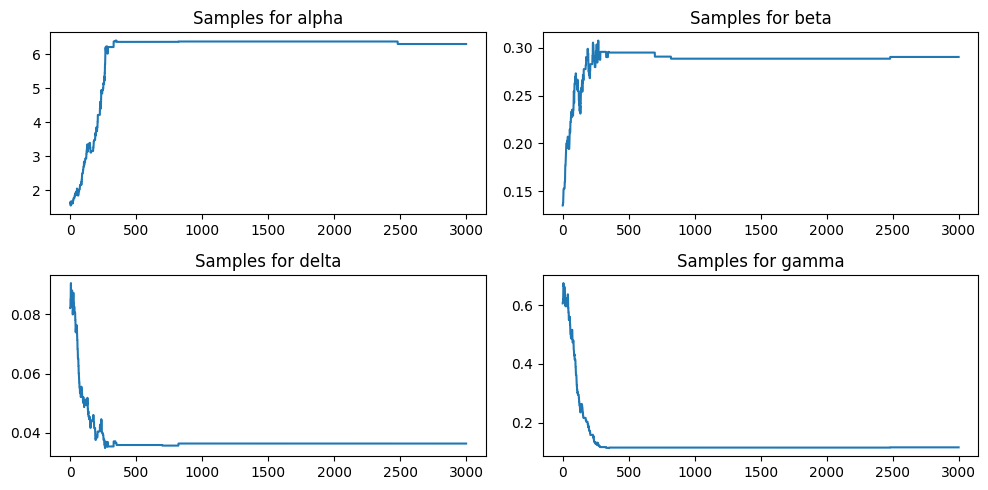

In [ ]:
# Plot the results
plt.figure(figsize=(10, 5))
for i, param in enumerate(['alpha', 'beta', 'delta', 'gamma']):
    plt.subplot(2, 2, i + 1)
    plt.plot(jnp.exp(mh_samples[:,i]))
    plt.title(f'Samples for {param}')
    #plt.ylim((0,5))
plt.tight_layout()
plt.show()

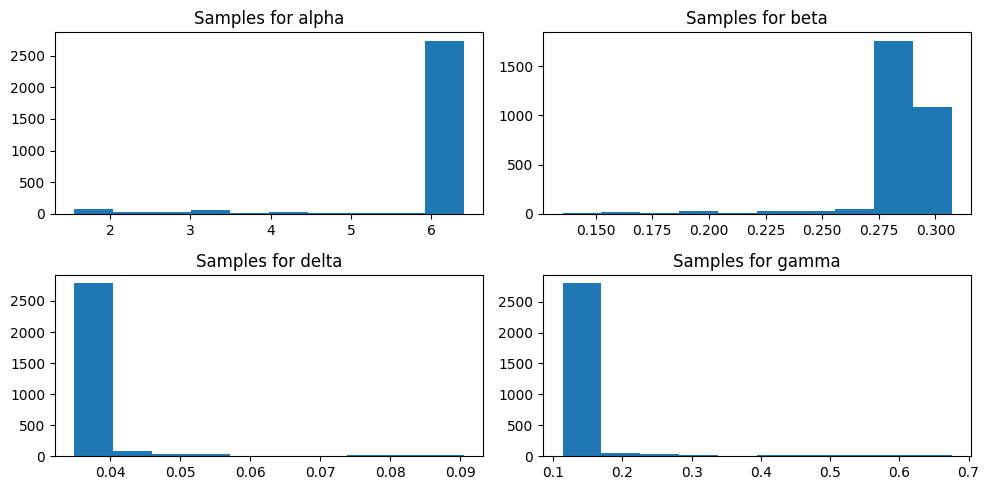

In [ ]:
# Plot the results
plt.figure(figsize=(10, 5))
for i, param in enumerate(['alpha', 'beta', 'delta', 'gamma']):
    plt.subplot(2, 2, i + 1)
    plt.hist(jnp.exp(mh_samples[:,i]))
    plt.title(f'Samples for {param}')
    #plt.ylim((0,5))
plt.tight_layout()
plt.show()